In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,plot_roc_curve
from sklearn.preprocessing import MinMaxScaler


In [2]:
df=pd.read_csv('../Resources/healthcare-dataset-stroke-data.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Clean up Data  PART 1  imputing BMI with Mean and encode string 

In [8]:
# drop ID column as it does not effect anything

In [9]:
df.drop('id',axis=1,inplace=True)

In [91]:
# for part 1 remove all missing values and unknown rows 
df.bmi.mean()

28.893236911794666

In [246]:
df_nonan=df.fillna(df.bmi.mean())
df_nonan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [101]:
# who are smokers ? attempt ot class unknown better way ?
smoke_df=df_nonan.loc[(df_nonan['smoking_status']=='smokes')|(df_nonan['smoking_status']=='previosly smoked')]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.800000,smokes,1
12,Female,54.0,0,0,Yes,Private,Urban,104.51,27.300000,smokes,1
16,Male,64.0,0,1,Yes,Private,Urban,191.61,37.500000,smokes,1
17,Male,75.0,1,0,Yes,Private,Urban,221.29,25.800000,smokes,1
...,...,...,...,...,...,...,...,...,...,...,...
5082,Female,44.0,0,0,Yes,Private,Rural,72.03,37.500000,smokes,0
5084,Male,67.0,0,0,Yes,Private,Rural,97.04,26.900000,smokes,0
5090,Male,26.0,0,0,No,Govt_job,Rural,100.85,21.000000,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,28.893237,smokes,0


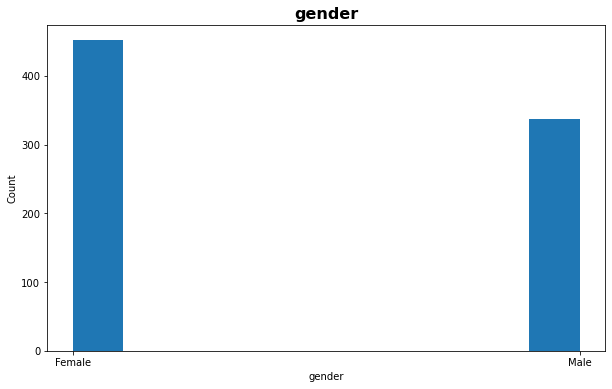

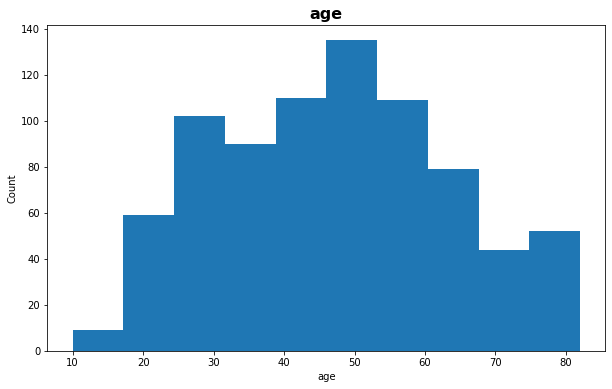

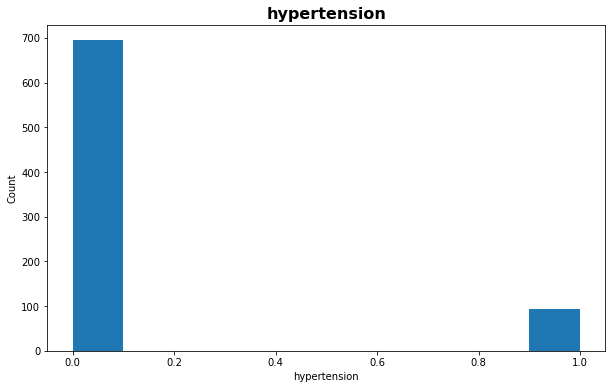

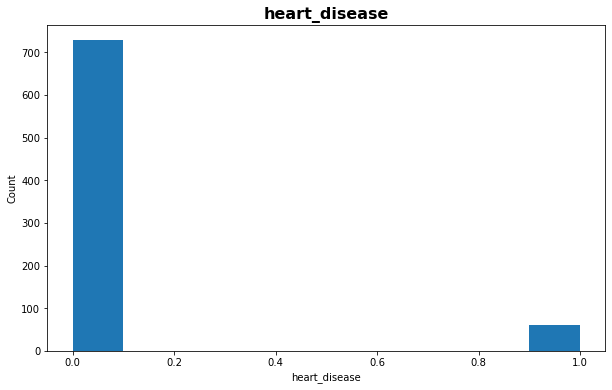

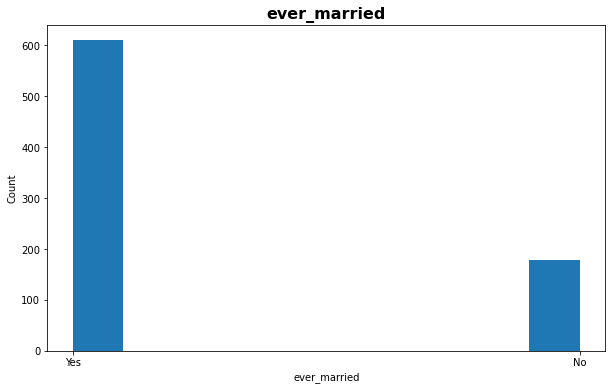

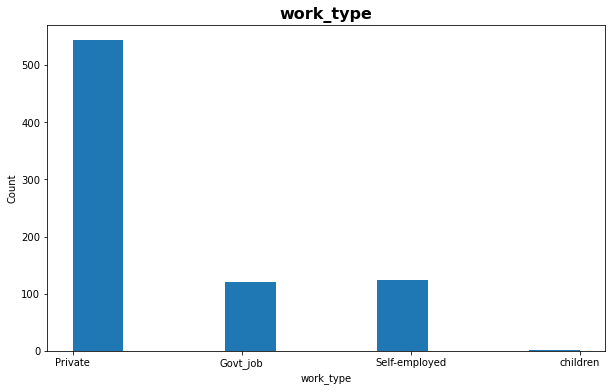

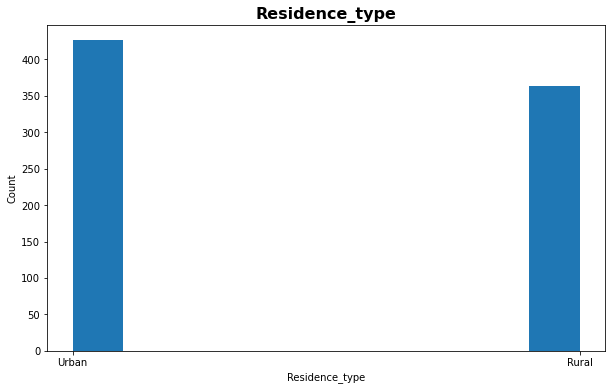

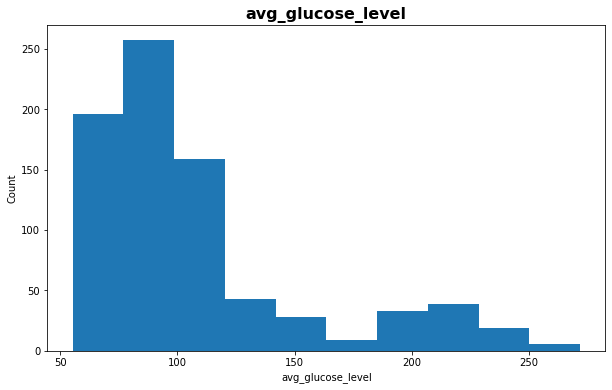

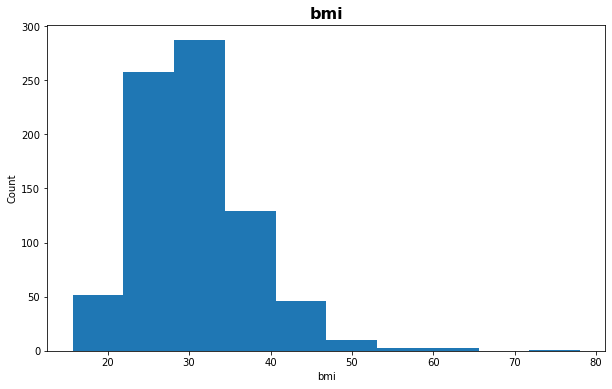

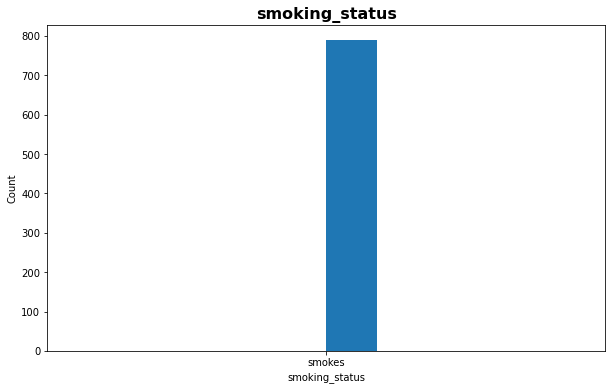

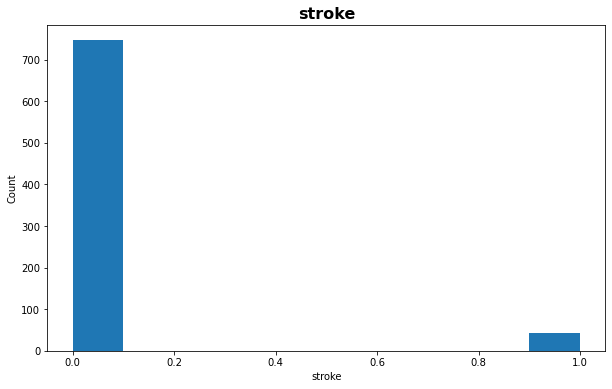

In [102]:
for col in smoke_df.columns:
    
    plt.figure(figsize=(10,6))
    plt.hist(smoke_df[col])
    plt.title(col, fontsize=16, fontweight="bold")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

In [247]:
#df_nonan.loc[(df_nonan.age<14)].smoking_status.replace('Unknown','never smoked', inplace=True)
#df_nonan.loc[(df_nonan.age<14)&(df_nonan.smoking_status=='Unknown'),'smoking_status']='never smoked'
df_nonan.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [248]:
# remove one unkown gender
#df_nomissing=df_nonan.loc[(df_nonan['smoking_status']!='Unknown')&(df_nonan['gender']!='Other')].reset_index(drop=True)
df_nomissing=df_nonan.loc[(df_nonan['gender']!='Other')].reset_index(drop=True)
df_nomissing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.2+ KB


In [249]:
df_nomissing.loc[df_nomissing['gender']=='Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [208]:
# Smoking Labels  combined (smokes and previously smoked )

In [250]:
target_labels = []
for _, row in df_nomissing.iterrows():
    if row.smoking_status == "Unknown":
        target_labels.append(0)
    elif row.smoking_status == "never smoked":
        target_labels.append(1)
    else:
        target_labels.append(2)
# target_labels = []
# for _, row in df_nomissing.iterrows():
#     if row.smoking_status == "never smoked":
#         target_labels.append(0)
#     else:
#         target_labels.append(1)

In [251]:
len(target_labels)

5109

In [252]:
df_nomissing["smoke_label"] = target_labels

In [253]:
# work Type labels

In [254]:
df_nomissing.work_type.value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [255]:
# label work type 
target_labels = []
for _, row in df_nomissing.iterrows():
    if row.work_type == "children":
        target_labels.append(0)
    elif row.work_type == "Never_worked":
        target_labels.append(1)
    elif row.work_type == "Govt_job":
        target_labels.append(2)
    elif row.work_type == "Self-employed":
        target_labels.append(3)
    else:
        target_labels.append(4)

In [256]:
df_nomissing["work_label"] = target_labels

In [257]:
df_nomissing.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'smoke_label', 'work_label'],
      dtype='object')

In [258]:
# gender, married, residence encoding

In [259]:
# one-hot encoding
dummies = pd.get_dummies(df_nomissing[['gender',"ever_married","Residence_type"]], drop_first=True) # ONLY FOR LINEAR MODELS
dummies

,gender_Male,ever_married_Yes,Residence_type_Urban
0,1,1,1
1,0,1,0
2,1,1,0
3,0,1,1
4,0,1,0
...,...,...,...
5104,0,1,1
5105,0,1,1
5106,0,1,0
5107,1,1,0


In [260]:
df_nomissing[["gender_label",'married_labels','residence_label']]=dummies 

In [261]:
df_nomissing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
 11  smoke_label        5109 non-null   int64  
 12  work_label         5109 non-null   int64  
 13  gender_label       5109 non-null   uint8  
 14  married_labels     5109 non-null   uint8  
 15  residence_label    5109 non-null   uint8  
dtypes: float64(3), int64(5),

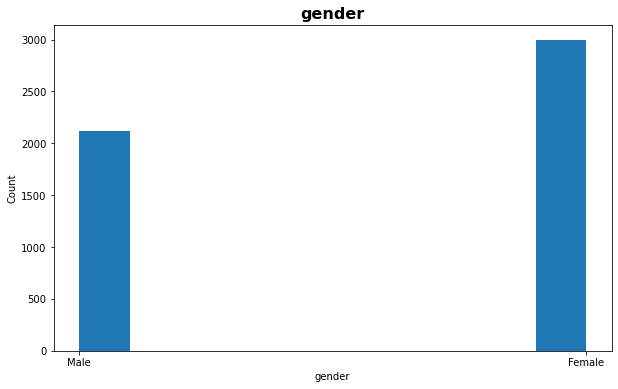

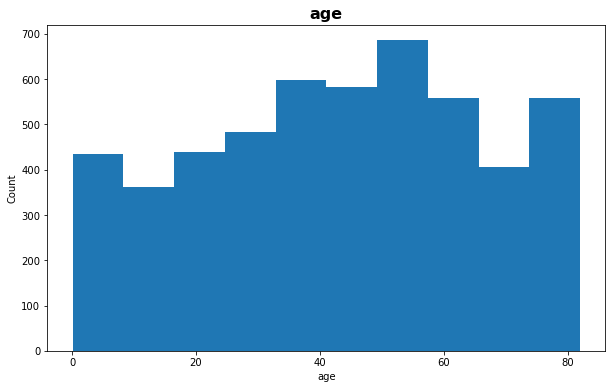

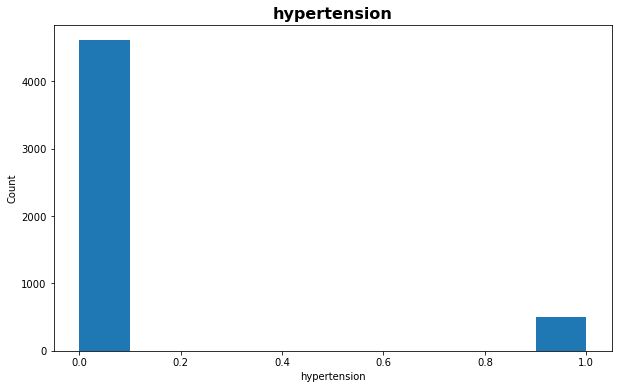

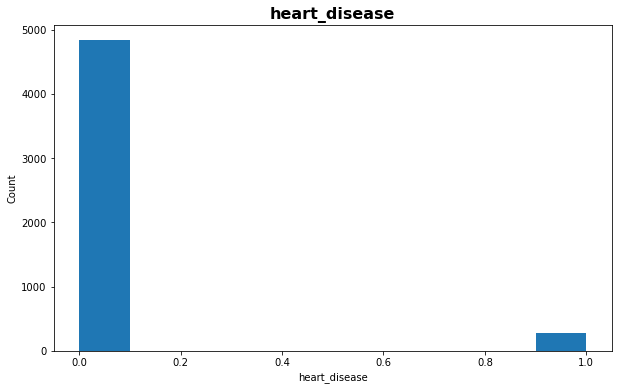

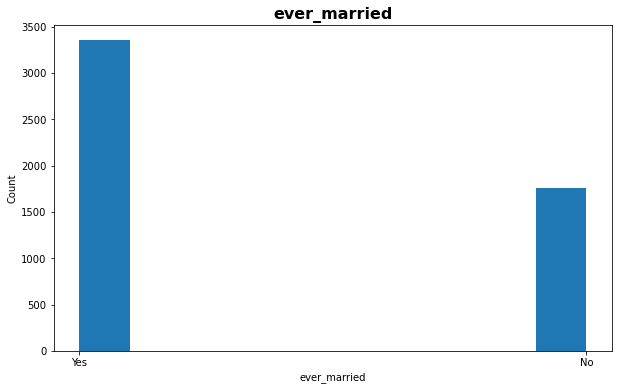

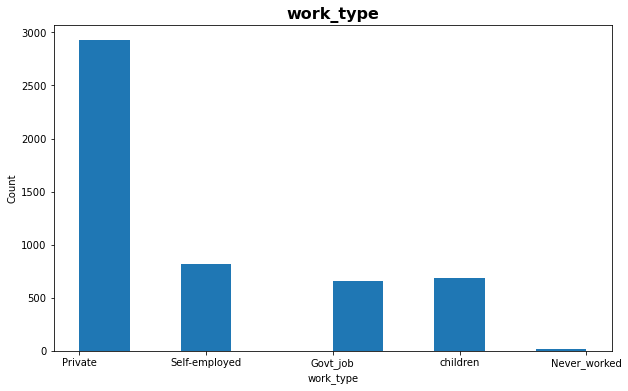

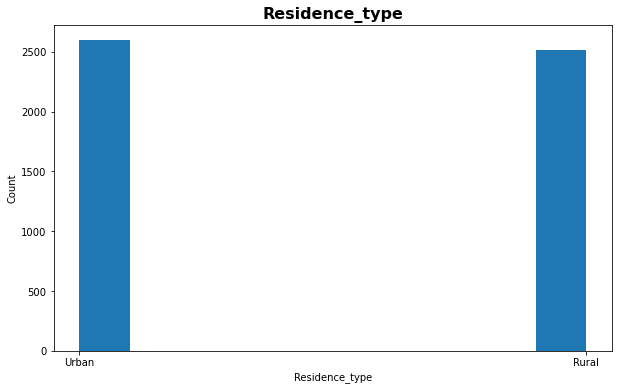

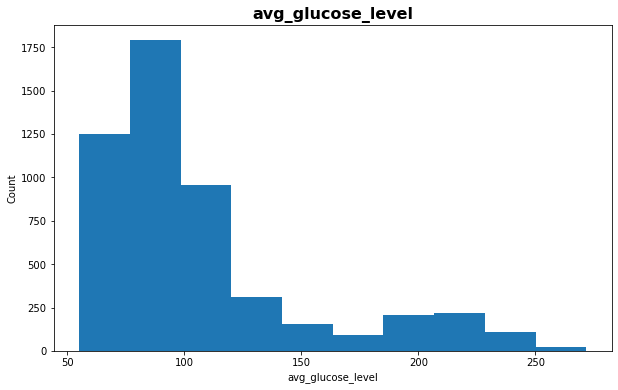

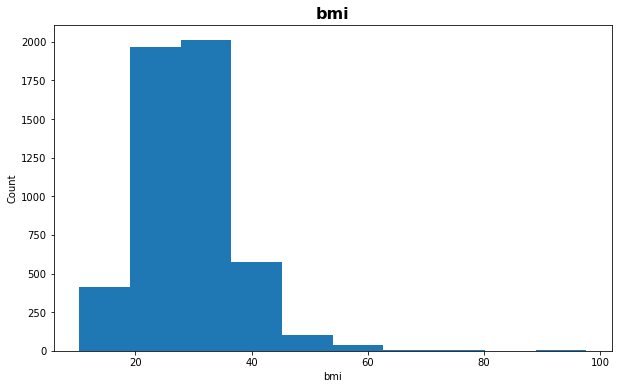

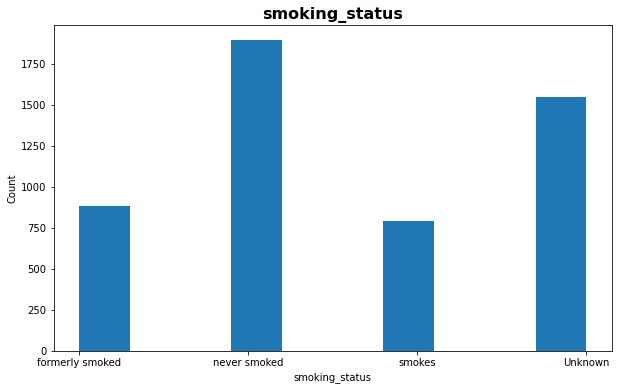

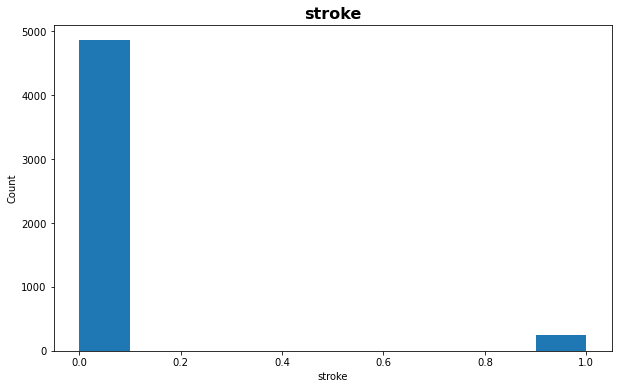

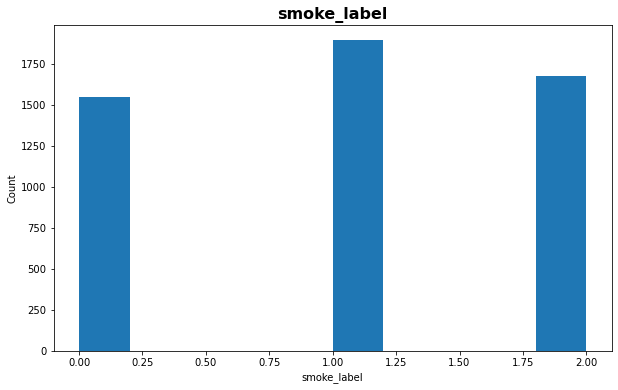

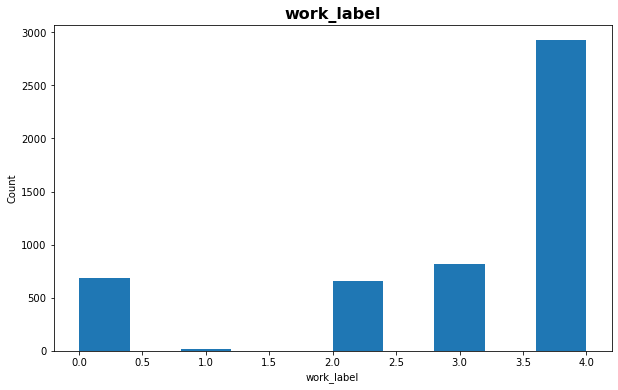

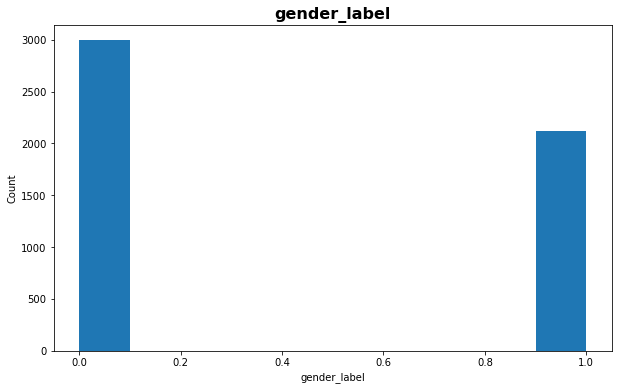

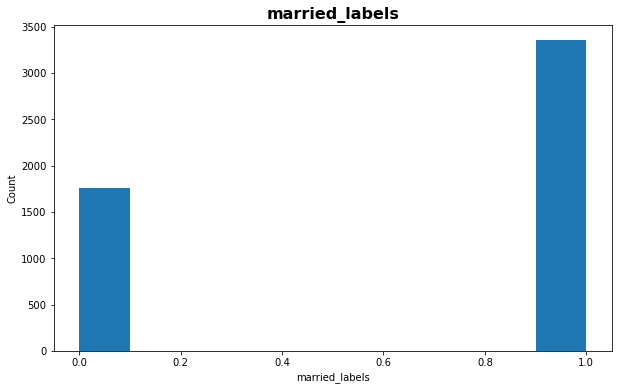

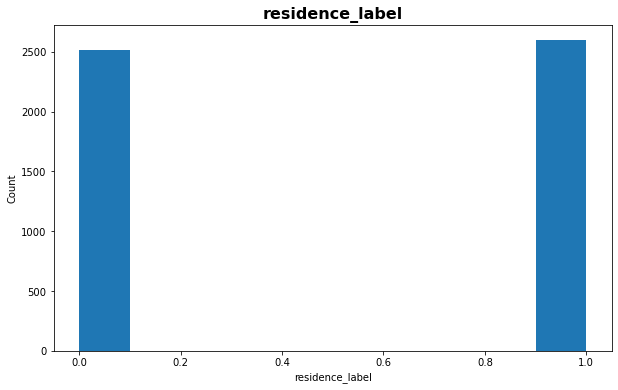

In [262]:
# data distribution
for col in df_nomissing.columns:
    
    plt.figure(figsize=(10,6))
    plt.hist(df_nomissing[col])
    plt.title(col, fontsize=16, fontweight="bold")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

In [263]:
clean_df=df_nomissing.select_dtypes(exclude='object')
clean_df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'smoke_label', 'work_label', 'gender_label', 'married_labels',
       'residence_label'],
      dtype='object')

<AxesSubplot:xlabel='smoke_label', ylabel='Density'>

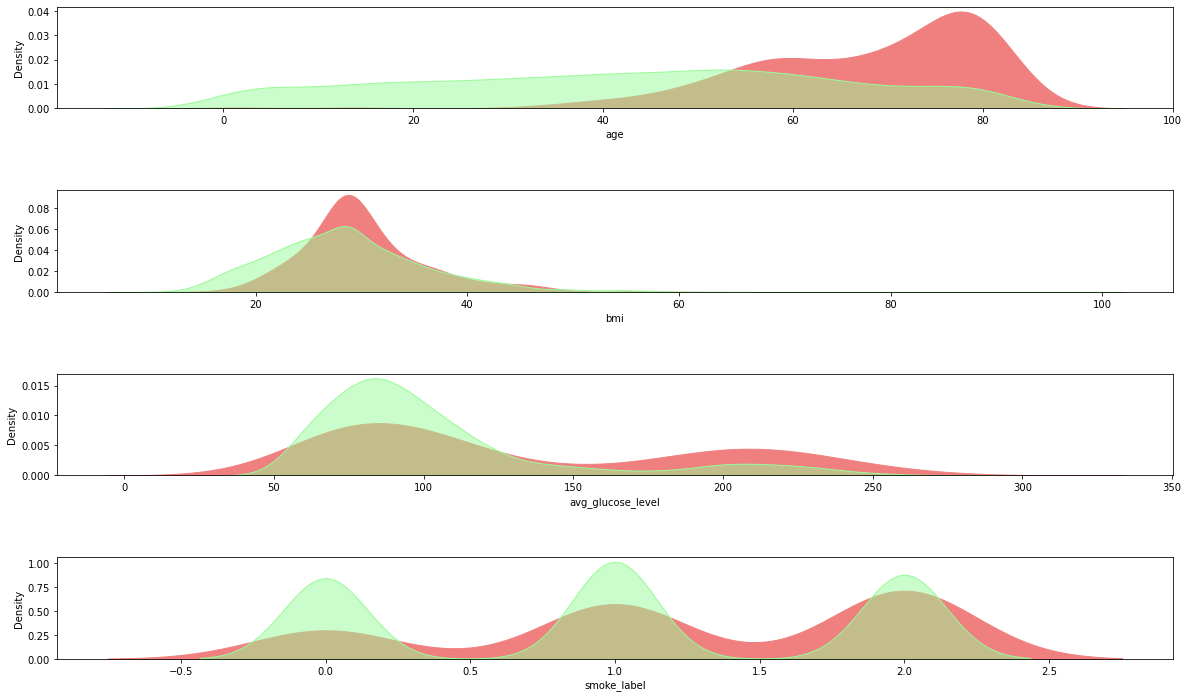

In [264]:
# plAY with overlAY 
fig=plt.figure(figsize=(20,12),facecolor='white')

ax=[None for i in range(4)]
gs=fig.add_gridspec(4,1)
gs.update(wspace=0, hspace=0.8)

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])
ax[2]=fig.add_subplot(gs[2,0])
ax[3]=fig.add_subplot(gs[3,0])
sns.kdeplot(data=clean_df[clean_df.stroke==1],x='age',ax=ax[0],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=clean_df[clean_df.stroke==0],x='age',ax=ax[0],shade=True,color='palegreen',alpha=0.5)

sns.kdeplot(data=clean_df[clean_df.stroke==1],x='bmi',ax=ax[1],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=clean_df[clean_df.stroke==0],x='bmi',ax=ax[1],shade=True,color='palegreen',alpha=0.5)

sns.kdeplot(data=clean_df[clean_df.stroke==1],x='avg_glucose_level',ax=ax[2],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=clean_df[clean_df.stroke==0],x='avg_glucose_level',ax=ax[2],shade=True,color='palegreen',alpha=0.5)

sns.kdeplot(data=clean_df[clean_df.stroke==1],x='smoke_label',ax=ax[3],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=clean_df[clean_df.stroke==0],x='smoke_label',ax=ax[3],shade=True,color='palegreen',alpha=0.5)

In [494]:
# corr table sorted by stroke correlations
clean_df.corr().sort_values(by=['stroke'], ascending=False)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoke_label,work_label,gender_label,married_labels,residence_label
stroke,0.245239,0.127891,0.134905,0.131991,0.038912,1.000000,0.067294,0.066857,0.009081,0.108299,0.015415
age,1.000000,0.276367,0.263777,0.238323,0.325858,0.245239,0.365570,0.485291,-0.027752,0.679084,0.014031
heart_disease,0.263777,0.108292,1.000000,0.161907,0.038862,0.134905,0.090644,0.068759,0.085685,0.114601,0.003045
avg_glucose_level,0.238323,0.174540,0.161907,1.000000,0.168910,0.131991,0.095432,0.079232,0.054722,0.155329,-0.004783
hypertension,0.276367,1.000000,0.108292,0.174540,0.160147,0.127891,0.124330,0.091365,0.021223,0.164187,-0.007980
married_labels,0.679084,0.164187,0.114601,0.155329,0.335563,0.108299,0.322338,0.432715,-0.030171,1.000000,0.005988
smoke_label,0.365570,0.124330,0.090644,0.095432,0.242377,0.067294,1.000000,0.377378,-0.008720,0.322338,0.017501
work_label,0.485291,0.091365,0.068759,0.079232,0.383182,0.066857,0.377378,1.000000,-0.074442,0.432715,-0.009960
bmi,0.325858,0.160147,0.038862,0.168910,1.000000,0.038912,0.242377,0.383182,-0.025606,0.335563,-0.000288
residence_label,0.014031,-0.007980,0.003045,-0.004783,-0.000288,0.015415,0.017501,-0.009960,-0.006105,0.005988,1.000000


## Establish columns importance based on correlations 

In [497]:
# set up columns used for prediction based on corr > 2%
corrs=abs(clean_df.corr()['stroke']).sort_values(ascending=False)
predictive_cols=[]
for name,col in corrs.iteritems():
    if col>0.00:
        predictive_cols.append(name)
predictive_cols

['stroke',
 'age',
 'heart_disease',
 'avg_glucose_level',
 'hypertension',
 'married_labels',
 'smoke_label',
 'work_label',
 'bmi',
 'residence_label',
 'gender_label']

In [498]:
predictive_cols

['stroke',
 'age',
 'heart_disease',
 'avg_glucose_level',
 'hypertension',
 'married_labels',
 'smoke_label',
 'work_label',
 'bmi',
 'residence_label',
 'gender_label']

<AxesSubplot:>

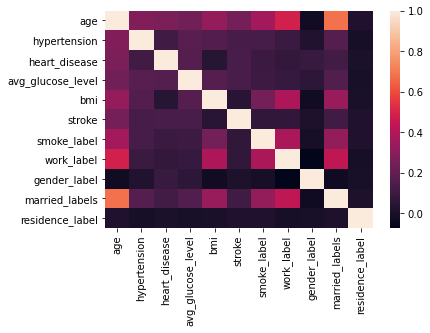

In [267]:
sns.heatmap(clean_df.corr())

In [499]:
predict_df=clean_df.loc[:,predictive_cols]
predict_df

,stroke,age,heart_disease,avg_glucose_level,hypertension,married_labels,smoke_label,work_label,bmi,residence_label,gender_label
0,1,67.0,1,228.69,0,1,2,4,36.600000,1,1
1,1,61.0,0,202.21,0,1,1,3,28.893237,0,0
2,1,80.0,1,105.92,0,1,1,4,32.500000,0,1
3,1,49.0,0,171.23,0,1,2,4,34.400000,1,0
4,1,79.0,0,174.12,1,1,1,3,24.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5104,0,80.0,0,83.75,1,1,1,4,28.893237,1,0
5105,0,81.0,0,125.20,0,1,1,3,40.000000,1,0
5106,0,35.0,0,82.99,0,1,1,3,30.600000,0,0
5107,0,51.0,0,166.29,0,1,2,4,25.600000,0,1


In [500]:
predict_df.columns

Index(['stroke', 'age', 'heart_disease', 'avg_glucose_level', 'hypertension',
       'married_labels', 'smoke_label', 'work_label', 'bmi', 'residence_label',
       'gender_label'],
      dtype='object')

## Library to fix imbalance in data set

In [359]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN

In [301]:
from collections import Counter

# FEATURES 

Before Counter({0: 3888, 1: 199})


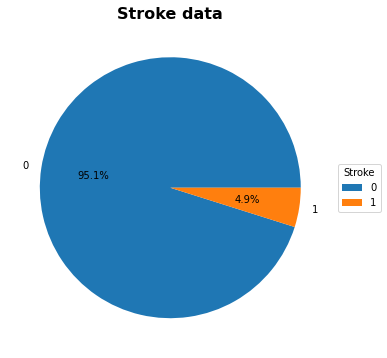

In [503]:
################################################# features
##########################################################
features = predict_df.drop('stroke',axis=1)
target = predict_df["stroke"]
X = features.to_numpy()
y = target.to_numpy()
scaler = MinMaxScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)
counter=Counter(y_train)
print('Before',counter)

# pie chart showing disbalnce 
##############################################
plt.figure(figsize=(10,6))
plt.pie(pd.Series(counter),autopct='%1.1f%%', labels=pd.Series(counter).index)
plt.title('Stroke data', fontsize=16, fontweight="bold")
plt.legend(pd.Series(counter).index,
          title="Stroke",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

## Synthesizing to Handle Imbalanced Class 

In [504]:
#smt=SMOTETomek(random_state=42)
smt=SMOTE(random_state=42)

After Counter({0: 3888, 1: 3888})


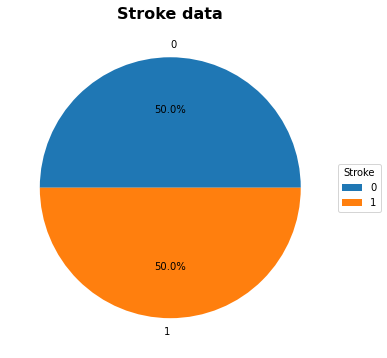

In [507]:
X_train, y_train = smt.fit_resample(X_train, y_train)

counter=Counter(y_train)
print('After',counter)

# pie chart 
plt.figure(figsize=(10,6))
plt.pie(pd.Series(counter),autopct='%1.1f%%', labels=pd.Series(counter).index)
plt.title('Stroke data', fontsize=16, fontweight="bold")
plt.legend(pd.Series(counter).index,
          title="Stroke",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

## linear Classifier

In [324]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier


Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      3888
           1       0.77      0.85      0.80      3888

    accuracy                           0.79      7776
   macro avg       0.80      0.79      0.79      7776
weighted avg       0.80      0.79      0.79      7776

In Sample Confusion Matrix: 
[[2880 1008]
 [ 595 3293]]


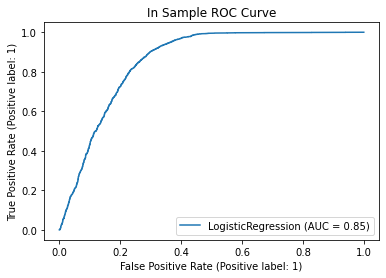


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

Out Sample Confusion Matrix: 
[[722 250]
 [ 10  40]]


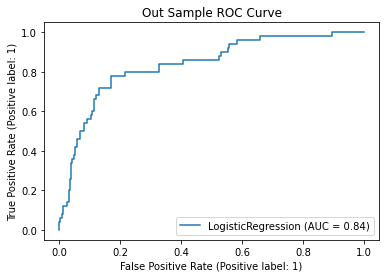

array([[0.74814098, 0.25185902],
       [0.93321727, 0.06678273],
       [0.90822645, 0.09177355],
       ...,
       [0.48879431, 0.51120569],
       [0.58409736, 0.41590264],
       [0.13926644, 0.86073356]])

In [506]:
################################################# initialize

classifier = LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42).fit(X_train, y_train)
#classifier=RidgeClassifier().fit(X_train, y_train)
#class_weight{“balanced”, “balanced_subsample”}

# predict
in_preds = classifier.predict(X_train)
out_preds = classifier.predict(X_test)


################################################# evaluate Classification

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(classifier, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(classifier, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

classifier.predict_proba(X_train)

In [350]:
X_test

array([[28.  ,  0.  , 83.66, ...,  1.  ,  2.  , 36.4 ],
       [ 3.  ,  0.  , 93.3 , ...,  0.  ,  0.  , 19.5 ],
       [53.  ,  0.  , 64.4 , ...,  2.  ,  2.  , 31.  ],
       ...,
       [37.  ,  0.  , 90.71, ...,  0.  ,  3.  , 45.8 ],
       [18.  ,  0.  , 79.35, ...,  0.  ,  4.  , 23.6 ],
       [46.  ,  0.  , 58.42, ...,  2.  ,  4.  , 24.7 ]])

In [401]:
#[ 'age', 'heart_disease', 'avg_glucose_level', 'hypertension', 'married_labels', 'smoke_label', 'work_label', 'bmi'],
myX=np.array([[50,1,100,1,0,2,4,23]])
classifier.predict_proba(myX)

array([[0., 1.]])

## KNeighborsClassifier

In [147]:
from sklearn.neighbors import KNeighborsClassifier

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3499
           1       0.93      0.99      0.96      3499

    accuracy                           0.96      6998
   macro avg       0.96      0.96      0.96      6998
weighted avg       0.96      0.96      0.96      6998

In Sample Confusion Matrix: 
[[3218  281]
 [  27 3472]]


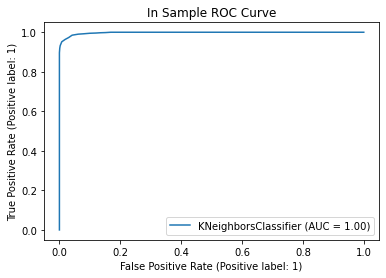


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.11      0.66      0.19        50

    accuracy                           0.72      1022
   macro avg       0.54      0.69      0.51      1022
weighted avg       0.93      0.72      0.80      1022

Out Sample Confusion Matrix: 
[[703 269]
 [ 17  33]]


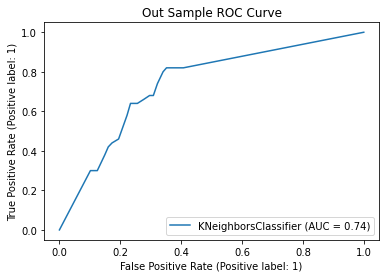

In [489]:
################################################# initialize

classifier = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)



# predict
in_preds = classifier.predict(X_train)
out_preds = classifier.predict(X_test)

################################################# evaluate Classification

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(classifier, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(classifier, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()


## Random Forests and Boosting 

In [149]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      3499
           1       0.90      0.96      0.93      3499

    accuracy                           0.93      6998
   macro avg       0.93      0.93      0.93      6998
weighted avg       0.93      0.93      0.93      6998

In Sample Confusion Matrix: 
[[3134  365]
 [ 151 3348]]


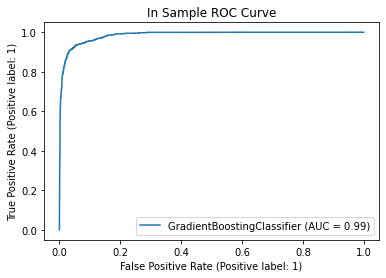


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.13      0.68      0.22        50

    accuracy                           0.76      1022
   macro avg       0.55      0.72      0.54      1022
weighted avg       0.94      0.76      0.83      1022

Out Sample Confusion Matrix: 
[[744 228]
 [ 16  34]]


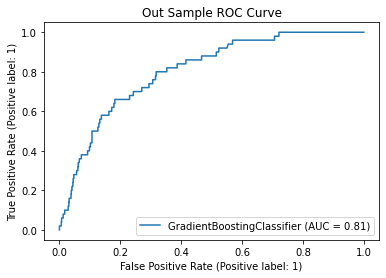

In [490]:

################################################# initialize
#classifier = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
#classifier = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True,random_state=42).fit(X_train, y_train)
classifier = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)


# predict
in_preds = classifier.predict(X_train)
out_preds = classifier.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(classifier, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(classifier, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

## SVM - SVC

In [157]:
from sklearn.svm import SVC

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3499
           1       0.88      0.93      0.90      3499

    accuracy                           0.90      6998
   macro avg       0.90      0.90      0.90      6998
weighted avg       0.90      0.90      0.90      6998

In Sample Confusion Matrix: 
[[3036  463]
 [ 228 3271]]


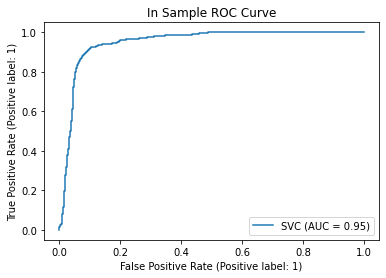


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       972
           1       0.12      0.78      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.72      0.80      1022

Out Sample Confusion Matrix: 
[[692 280]
 [ 11  39]]


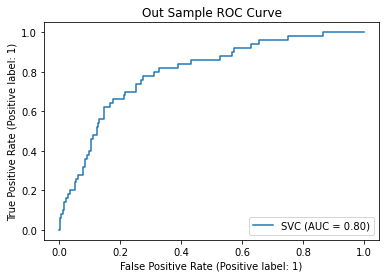

In [491]:
################################################# initialize

classifier = SVC().fit(X_train, y_train)



# predict
in_preds = classifier.predict(X_train)
out_preds = classifier.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(classifier, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(classifier, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

## XGBoost

In [159]:
from xgboost import XGBClassifier

C:\Users\ykras\anaconda3\envs\ml\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:36:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3888
           1       1.00      0.99      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776

In Sample Confusion Matrix: 
[[3884    4]
 [  28 3860]]


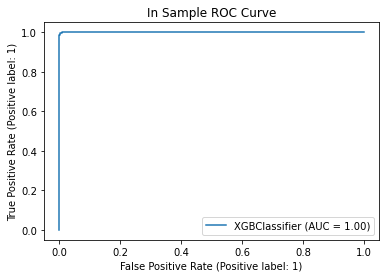


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.16      0.12      0.14        50

    accuracy                           0.93      1022
   macro avg       0.56      0.54      0.55      1022
weighted avg       0.92      0.93      0.92      1022

Out Sample Confusion Matrix: 
[[941  31]
 [ 44   6]]


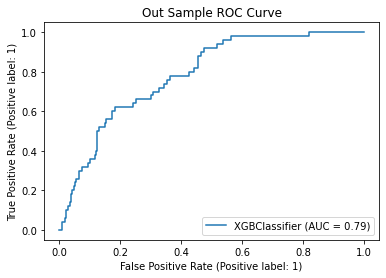

In [508]:

################################################# initialize

classifier = XGBClassifier().fit(X_train, y_train)



# predict
in_preds = classifier.predict(X_train)
out_preds = classifier.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(classifier, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(classifier, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

## Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.86      0.89      3499
           1       0.87      0.94      0.90      3499

    accuracy                           0.90      6998
   macro avg       0.90      0.90      0.90      6998
weighted avg       0.90      0.90      0.90      6998

In Sample Confusion Matrix: 
[[2998  501]
 [ 204 3295]]


C:\Users\ykras\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


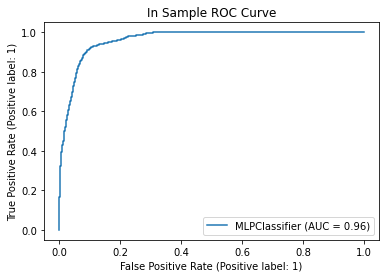


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.11      0.70      0.19        50

    accuracy                           0.72      1022
   macro avg       0.55      0.71      0.51      1022
weighted avg       0.94      0.72      0.80      1022

Out Sample Confusion Matrix: 
[[697 275]
 [ 15  35]]


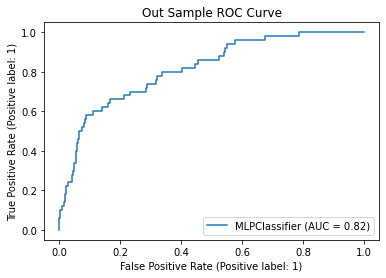

In [493]:

################################################# initialize

classifier = MLPClassifier(random_state=42).fit(X_train, y_train)



# predict
in_preds = classifier.predict(X_train)
out_preds = classifier.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(classifier, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(classifier, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()